In [1]:
import warnings
warnings.filterwarnings('ignore')

In [88]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk

In [19]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib

In [77]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam

In [5]:
from sklearn.model_selection import train_test_split

In [28]:
from google.colab import files, drive

In [29]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [31]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/Natural_Language_Processing/data

total 6195845
-rw------- 1 root root 3644258522 Mar 27 14:06 GoogleNews-vectors-negative300.bin
-rw------- 1 root root 1647046227 Mar 27 14:06 GoogleNews-vectors-negative300.bin.gz
-rw------- 1 root root  745420346 Mar 27 10:34 kowiki-latest-pages-articles.xml.bz2
-rw------- 1 root root   80596565 Mar 27 14:10 ko.zip
-rw------- 1 root root   16035163 Mar 27 02:02 ted_en-20160408.zip
-rw------- 1 root root    3283420 Mar 28 09:20 train_tagging.txt
-rw------- 1 root root  207903212 Nov 18 12:30 wiki_data.txt


In [32]:
f = open('/content/drive/My Drive/Colab Notebooks/Natural_Language_Processing/data/train_tagging.txt', 'r')

## 1. Data Preprocessing

In [33]:
%%time
tagged_sentences = []
sentence = []

for line in f :
  if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == '\n' :
    if len(sentence) > 0 :
      tagged_sentences.append(sentence)
      sentence = []
    continue
  splits = line.split(' ')                      # 공백을 기준으로 속성을 구분
  splits[-1] = re.sub(r'\n' , '' , splits[-1])  # 줄바꿈 표시 \n을 제거
  word = splits[0].lower()                      # 단어들을 소문자로 바꿔서 저장
  sentence.append([word, splits[-1]])           # 단어와 개체명 태깅만 기록

CPU times: user 724 ms, sys: 55.9 ms, total: 780 ms
Wall time: 1.39 s


In [34]:
# 전체 샘플 개수
len(tagged_sentences)

14041

In [35]:
# 첫번째 샘플
tagged_sentences[0]

[['eu', 'B-ORG'],
 ['rejects', 'O'],
 ['german', 'B-MISC'],
 ['call', 'O'],
 ['to', 'O'],
 ['boycott', 'O'],
 ['british', 'B-MISC'],
 ['lamb', 'O'],
 ['.', 'O']]

### 1) 단어와 태킹 분리 후 저장(zip함수 사용)

In [37]:
%%time
sentences , ner_tags = [] , []

for tagged_sentence in tagged_sentences :     # 14,041개의 문장 샘플을 하나씩 불러옴
  sentence , tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에, 개체명 태깅정보는 tag_info에 저장
  sentences.append(list(sentence))            # 각 샘플에서 단어 정보만 저장
  ner_tags.append(list(tag_info))             # 각 샘플에서 개체명 태깅정보만 저장

CPU times: user 46.5 ms, sys: 3.75 ms, total: 50.2 ms
Wall time: 51.7 ms


In [38]:
sentences[0] , ner_tags[0]

(['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'])

### 2) 전체 데이터의 길이 분포 확인

샘플의 최대 길이: 113
샘플의 평균 길이: 14.501887


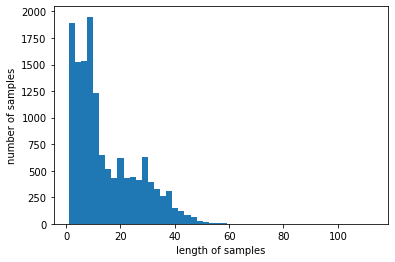

In [39]:
print('샘플의 최대 길이: %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이: %f' % (sum(map(len, sentences))/len(sentences)))

plt.hist([len(s) for s in sentences] , bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 대체로 0~40 사이
- 특히 0~20 길이를 가진 샘플이 상당한 비율을 차지


### 3) 토큰화, 정수 인코딩
- 케라스 토크나이저

In [40]:
# 높은 빈도를 가진 상위 4000개 단어만 사용
max_words = 4000

src_tokenizer = Tokenizer(num_words = max_words, oov_token = 'OOV') # 문장데이터
tar_tokenizer = Tokenizer() # 개체명 태길정보

src_tokenizer.fit_on_texts(sentences)
tar_tokenizer.fit_on_texts(ner_tags)

In [42]:
tar_tokenizer.word_index

{'b-loc': 2,
 'b-misc': 7,
 'b-org': 4,
 'b-per': 3,
 'i-loc': 8,
 'i-misc': 9,
 'i-org': 6,
 'i-per': 5,
 'o': 1}

In [44]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1

print('단어 집합의 크기: {}' .format(vocab_size))
print('개체명 태깅 정보 집합의 크기: {}' .format(tag_size))

단어 집합의 크기: 4000
개체명 태깅 정보 집합의 크기: 10


- 정수 인코딩

In [63]:
X = src_tokenizer.texts_to_sequences(sentences)
y = tar_tokenizer.texts_to_sequences(ner_tags)

In [64]:
X[0] , y[0]

([989, 1, 205, 629, 7, 3939, 216, 1, 3], [4, 1, 7, 1, 1, 1, 7, 1, 1])

### 4) OOV로 대체된 단어 확인

In [47]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [54]:
decoded = []

for index in X[0] :
  decoded.append(index_to_word[index]) # 첫번째 샘플의 인덱스에 해당하는 단어로 변환

print('기존문장: {}' .format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장: {}' .format(decoded))

기존문장: ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장: ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [67]:
max_len = 70

X = pad_sequences(X, padding = 'post' , maxlen = max_len)
y = pad_sequences(y, padding = 'post' , maxlen = max_len)

In [70]:
y = to_categorical(y, num_classes = tag_size)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state = 2046)

In [72]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11232, 70), (11232, 70, 10), (2809, 70), (2809, 70, 10))

## 2. Bi-LSTM 개체명 인식기 만들기

In [82]:
model = Sequential()

model.add(Embedding(input_dim = vocab_size,
                    output_dim = 128,
                    input_length = max_len,
                    mask_zero = True))
model.add(Bidirectional(LSTM(256, return_sequences = True)))
model.add(TimeDistributed(Dense(tag_size, activation = 'softmax')))

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 128)           512000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 512)           788480    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 10)            5130      
Total params: 1,305,610
Trainable params: 1,305,610
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(0.001),
              metrics = ['accuracy'])

In [85]:
%%time

hist = model.fit(X_train, y_train,
          batch_size = 128,
          epochs = 50,
          validation_data = (X_test, y_test))

Epoch 1/50
88/88 [==============================] - 11s 52ms/step - loss: 0.2591 - accuracy: 0.7844 - val_loss: 0.1257 - val_accuracy: 0.8344
Epoch 2/50
88/88 [==============================] - 2s 27ms/step - loss: 0.1026 - accuracy: 0.8479 - val_loss: 0.0737 - val_accuracy: 0.8945
Epoch 3/50
88/88 [==============================] - 2s 27ms/step - loss: 0.0642 - accuracy: 0.9069 - val_loss: 0.0538 - val_accuracy: 0.9260
Epoch 4/50
88/88 [==============================] - 2s 26ms/step - loss: 0.0457 - accuracy: 0.9352 - val_loss: 0.0415 - val_accuracy: 0.9428
Epoch 5/50
88/88 [==============================] - 2s 26ms/step - loss: 0.0352 - accuracy: 0.9512 - val_loss: 0.0357 - val_accuracy: 0.9498
Epoch 6/50
88/88 [==============================] - 2s 27ms/step - loss: 0.0272 - accuracy: 0.9620 - val_loss: 0.0356 - val_accuracy: 0.9503
Epoch 7/50
88/88 [==============================] - 2s 26ms/step - loss: 0.0234 - accuracy: 0.9670 - val_loss: 0.0332 - val_accuracy: 0.9534
Epoch 8/50
8

## 3. Model Evaluate

In [86]:
accuracy = model.evaluate(X_test, y_test)[1]

print("Accuracy: {:.4f}" .format(accuracy))

88/88 [==============================] - 1s 7ms/step - loss: 0.0639 - accuracy: 0.9532
Accuracy: 0.9532


### 1) 실제값과 비교

In [87]:
i = 10  # 확인하고 싶은 테스트용 샘플의 인덱스

y_hat = model.predict(np.array([X_test[i]]))
y_hat = np.argmax(y_hat, axis = -1) # 원핫인코딩을 정수인코딩으로 변환
y_true = np.argmax(y_test[i], axis = -1)

print('{:15}|{:5}|{}' .format('단어' , '실제값' , '예측값'))
print('-' * 35)

for w, t, pred in zip(X_test[i], y_true, y_hat[0]) :
  if w != 0 : # pad 값은 제외
    print('{:17}: {:7} {}' .format(index_to_word[w],
                                   index_to_ner[t].upper(),
                                   index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
iss              : B-ORG   B-ORG
says             : O       O
agreed           : O       O
sale             : O       O
of               : O       O
u.s.             : B-LOC   B-ORG
unit             : O       O
.                : O       O
